# Tuning Neural Networks with Regularization - Lab

## Introduction

Recall from the last lab that you had a training accuracy close to 90% and a test set accuracy close to 76%.

As with your previous machine learning work, you should be asking a couple of questions:
- Is there high bias? yes/no
- Is there high variance? yes/no 

In this lab, you'll use the a train-validate-test partition as well as a validation set to get better insights of how to tune neural networks using regularization techniques. You'll start by repeating the process from the last section: importing the data and performing preprocessing including one-hot encoding. From there, you'll define and compile the model like before. However, this time, when you are presented with the `history` dictionary of the model, you will have additional data entries for not only the train and test set but also the validation set.

## Objectives

You will be able to:

* Construct and run a basic model in Keras
* Construct a validation set and explain potential benefits
* Apply L1 and L2 regularization
* Apply dropout regularization
* Observe and comment on the effect of using more data

## Import the libraries

As usual, start by importing some of the packages and modules that you intend to use. The first thing you'll be doing is importing the data and taking a random sample, so that should clue you in to what tools to import. If you need more tools down the line, you can always import additional packages later.

In [17]:
#Your code here; import some packages/modules you plan to use
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer

## Load the Data

As with the previous lab, the data is stored in a file **Bank_complaints.csv**. Load and preview the dataset.

In [18]:
#Your code here; load and preview the dataset
df = pd.read_csv('Bank_complaints.csv')
df.head()

,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


## Preprocessing Overview

Before you begin to practice some of your new tools regarding regularization and optimization, let's practice munging some data as you did in the previous section with bank complaints. Recall some techniques:

* Train - test split
* Sampling in order to reduce training time (investigate model accuracy vs data size later on)
* One-hot encoding your complaint text
* Transforming your category labels

## Preprocessing: Generate a Random Sample

Since you have quite a bit of data and training networks takes a substantial amount of time and resources, downsample in order to test your initial pipeline. Going forward, these can be interesting areas of investigation: how does your models performance change as you increase (or decrease) the size of your dataset?  

Generate the random sample using seed 123 for consistency of results. Make your new sample have 10,000 observations.

In [19]:
df = df.sample(10_000, random_state=123)
y = df['Product']
X = df['Consumer complaint narrative']

## Train-test Split

Below, perform an appropriate train test split.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1500, random_state=42)

## Running the model using a validation set.

## Creating the Validation Set

In the lecture, you saw that in deep learning, you generally set aside a validation set, which is then used during hyperparameter tuning. Afterwards, when you have decided upon a final model, the test can then be used to define the final model perforance. 

In this example, take the first 1000 cases out of the training set to create a validation set. You should do this for both `train` and `label_train`.

In [21]:
#Just run this block of code 

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=1000, random_state=123)

## Preprocessing: One-hot Encoding of the Complaints

As before, you need to do some preprocessing and data manipulationg before building the neural network. 

Keep the 2,000 most common words and use one-hot encoding to reformat the complaints into a matrix of vectors.

In [22]:
#Your code here; use one-hot encoding to reformat the complaints into a matrix of vectors.
#Only keep the 2000 most common words.
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train_final)

X_train_tok = tokenizer.texts_to_matrix(X_train_final, mode='binary')
X_val = tokenizer.texts_to_matrix(X_val, mode='binary')

## Preprocessing: Encoding the Products

Similarly, now transform the descriptive product labels to integers labels. After transforming them to integer labels, retransform them into a matrix of binary flags, one for each of the various product labels.  
  
> **Note**: This is similar to your previous work with dummy variables. Each of the various product categories will be its own column, and each observation will be a row. In turn, each of these observation rows will have a 1 in the column associated with it's label, and all other entries for the row will be zero.

In [23]:
#Your code here; transform the product labels to numerical values
lb = LabelBinarizer()
lb.fit(y_train_final)

y_train_lb = to_categorical(lb.transform(y_train_final))[:, :, 1]
y_val = to_categorical(lb.transform(y_val))[:, :, 1]

## Creating the Model

Rebuild a fully connected (Dense) layer network with relu activations in Keras.

Recall that you used 2 hidden with 50 units in the first layer and 25 in the second, both with a `relu` activation function. Because you are dealing with a multiclass problem (classifying the complaints into 7 classes), use a softmax classifyer in order to output 7 class probabilities per case. 

In [24]:
#Your code here; build a neural network using Keras as described above.
random.seed(123)
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

## Compiling the Model
In the compiler, you'll be passing the optimizer, loss function, and metrics. Train the model for 120 epochs in mini-batches of 256 samples. This time, include the argument `validation_data` and assign it `(val, label_val)`

In [25]:
model.compile(optimizer='SGD',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## Training the Model

Ok, now for the resource intensive part: time to train your model! Note that this is where you also introduce the validation data to the model.

In [26]:
#Code provided; note the extra validation parameter passed.
model_val = model.fit(X_train_tok,
                    y_train_lb,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 75us/step - loss: 1.9441 - accuracy: 0.1621 - val_loss: 1.9427 - val_accuracy: 0.1520
Epoch 2/120
7500/7500 [==============================] - ETA: 0s - loss: 1.9199 - accuracy: 0.17 - 1s 87us/step - loss: 1.9196 - accuracy: 0.1803 - val_loss: 1.9255 - val_accuracy: 0.1710
Epoch 3/120
7500/7500 [==============================] - 1s 113us/step - loss: 1.9015 - accuracy: 0.2064 - val_loss: 1.9102 - val_accuracy: 0.1950
Epoch 4/120
7500/7500 [==============================] - 1s 103us/step - loss: 1.8837 - accuracy: 0.2287 - val_loss: 1.8948 - val_accuracy: 0.2070
Epoch 5/120
7500/7500 [==============================] - 1s 128us/step - loss: 1.8655 - accuracy: 0.2460 - val_loss: 1.8786 - val_accuracy: 0.2150
Epoch 6/120
7500/7500 [==============================] - 1s 110us/step - loss: 1.8455 - accuracy: 0.2623 - val_loss: 1.8602 - val_accuracy: 0.2290
Epoch 7/120
7500/7500 [=======

Epoch 56/120
7500/7500 [==============================] - 1s 99us/step - loss: 0.6194 - accuracy: 0.7972 - val_loss: 0.7727 - val_accuracy: 0.7300
Epoch 57/120
7500/7500 [==============================] - 1s 97us/step - loss: 0.6126 - accuracy: 0.7988 - val_loss: 0.7669 - val_accuracy: 0.7310
Epoch 58/120
7500/7500 [==============================] - 1s 110us/step - loss: 0.6057 - accuracy: 0.8019 - val_loss: 0.7653 - val_accuracy: 0.7240
Epoch 59/120
7500/7500 [==============================] - 1s 115us/step - loss: 0.5987 - accuracy: 0.8037 - val_loss: 0.7596 - val_accuracy: 0.7350
Epoch 60/120
7500/7500 [==============================] - 1s 115us/step - loss: 0.5924 - accuracy: 0.8072 - val_loss: 0.7564 - val_accuracy: 0.7370
Epoch 61/120
7500/7500 [==============================] - 1s 117us/step - loss: 0.5860 - accuracy: 0.8087 - val_loss: 0.7538 - val_accuracy: 0.7380
Epoch 62/120
7500/7500 [==============================] - 1s 113us/step - loss: 0.5793 - accuracy: 0.8099 - val_lo

7500/7500 [==============================] - 1s 93us/step - loss: 0.3770 - accuracy: 0.8848 - val_loss: 0.7158 - val_accuracy: 0.7450
Epoch 112/120
7500/7500 [==============================] - 1s 115us/step - loss: 0.3741 - accuracy: 0.8841 - val_loss: 0.7106 - val_accuracy: 0.7570
Epoch 113/120
7500/7500 [==============================] - 1s 116us/step - loss: 0.3713 - accuracy: 0.8876 - val_loss: 0.7085 - val_accuracy: 0.7540
Epoch 114/120
7500/7500 [==============================] - 1s 113us/step - loss: 0.3680 - accuracy: 0.8877 - val_loss: 0.7098 - val_accuracy: 0.7600
Epoch 115/120
7500/7500 [==============================] - 1s 114us/step - loss: 0.3653 - accuracy: 0.8889 - val_loss: 0.7134 - val_accuracy: 0.7510
Epoch 116/120
7500/7500 [==============================] - 1s 113us/step - loss: 0.3625 - accuracy: 0.8888 - val_loss: 0.7148 - val_accuracy: 0.7560
Epoch 117/120
7500/7500 [==============================] - 1s 117us/step - loss: 0.3597 - accuracy: 0.8909 - val_loss: 0.

## Retrieving Performance Results: the `history` dictionary

The dictionary `history` contains four entries this time: one per metric that was being monitored during training and during validation.

In [27]:
model_val_dict = model_val.history
model_val_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [28]:
results_train = model.evaluate(X_train_tok, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

7500/7500 [==============================] - 1s 99us/step
Training Loss: 0.35 Training Accuracy: 0.89


## Preprocess then evaluate our models performance on the test set

In [29]:
X_test_tok = tokenizer.texts_to_matrix(X_test, mode='binary')
y_test_cat = to_categorical(lb.transform(y_test))[:, :, 1]

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

1500/1500 [==============================] - 0s 47us/step
Testing Loss: 0.592 Testing Accuracy: 0.779


In [30]:
model.metrics_names

['loss', 'accuracy']

The first element of the list returned by `model.evaluate` is the loss, and the second is the accuracy score. 

Note that the result you obtained here isn't exactly the same as before. This is because the training set is slightly different! You removed 1000 instances for validation!

## Plotting the Results

Plot the loss function versus the number of epochs. Be sure to include the training and the validation loss in the same plot. Then, create a second plot comparing training and validation accuracy to the number of epochs.

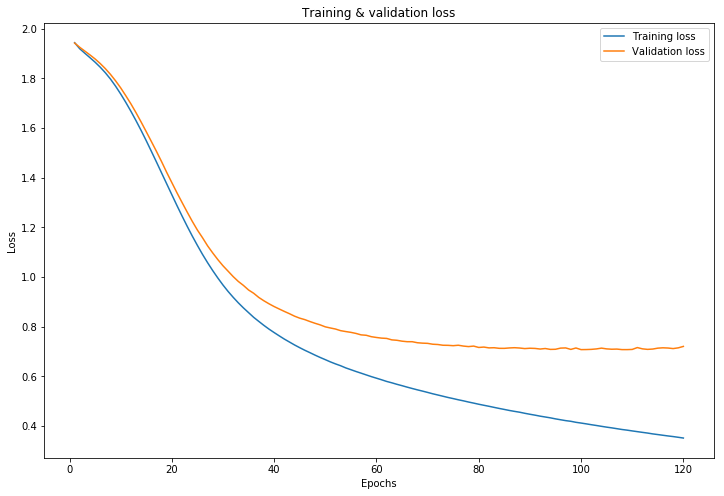

In [31]:
# Loss vs number of epochs with train and val set
fig, ax = plt.subplots(figsize=(12, 8))

loss_values = model_val_dict['loss']
val_loss_values = model_val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
ax.plot(epochs, loss_values, label='Training loss')
ax.plot(epochs, val_loss_values, label='Validation loss')

ax.set_title('Training & validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

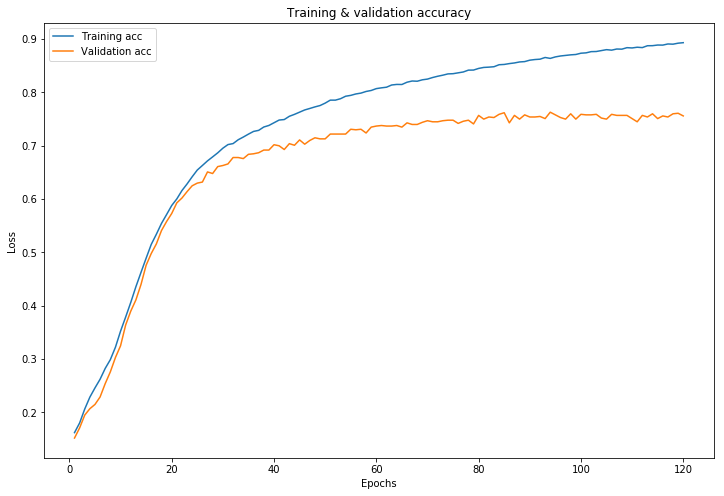

In [32]:
# Accuracy vs number of epochs with train and val set
fig, ax = plt.subplots(figsize=(12, 8))

acc_values = model_val_dict['accuracy'] 
val_acc_values = model_val_dict['val_accuracy']

ax.plot(epochs, acc_values, label='Training acc')
ax.plot(epochs, val_acc_values, label='Validation acc')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

Notice an interesting pattern here: although the training accuracy keeps increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy and loss seem to be reaching a limit around the 60th epoch. This means that you're probably **overfitting** the model to the training data when you train for many epochs past this dropoff point of around 40 epochs. Luckily, you learned how to tackle overfitting in the previous lecture! Since it seems clear that you are training too long, include early stopping at the 60th epoch first.

## Early Stopping

Below, observe how to update the model to include an earlier cutoff point:

In [33]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model = model.fit(X_train_tok,
                    y_train_lb,
                    epochs=60,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/60
7500/7500 [==============================] - 1s 77us/step - loss: 1.9751 - accuracy: 0.1419 - val_loss: 1.9622 - val_accuracy: 0.1300
Epoch 2/60
7500/7500 [==============================] - 0s 56us/step - loss: 1.9389 - accuracy: 0.1831 - val_loss: 1.9390 - val_accuracy: 0.1590
Epoch 3/60
7500/7500 [==============================] - 1s 86us/step - loss: 1.9172 - accuracy: 0.2067 - val_loss: 1.9208 - val_accuracy: 0.1870
Epoch 4/60
7500/7500 [==============================] - 1s 103us/step - loss: 1.8960 - accuracy: 0.2235 - val_loss: 1.9020 - val_accuracy: 0.2150
Epoch 5/60
7500/7500 [==============================] - 1s 99us/step - loss: 1.8726 - accuracy: 0.2364 - val_loss: 1.8798 - val_accuracy: 0.2190
Epoch 6/60
7500/7500 [==============================] - 1s 102us/step - loss: 1.8452 - accuracy: 0.2571 - val_loss: 1.8533 - val_accuracy: 0.2300
Epoch 7/60
7500/7500 [==============================] - 1s 85us/step - loss: 1.8

Epoch 57/60
7500/7500 [==============================] - 1s 107us/step - loss: 0.6348 - accuracy: 0.7753 - val_loss: 0.7972 - val_accuracy: 0.7100
Epoch 58/60
7500/7500 [==============================] - 1s 115us/step - loss: 0.6286 - accuracy: 0.7781 - val_loss: 0.7964 - val_accuracy: 0.7090
Epoch 59/60
7500/7500 [==============================] - 1s 83us/step - loss: 0.6225 - accuracy: 0.7813 - val_loss: 0.7952 - val_accuracy: 0.7120
Epoch 60/60
7500/7500 [==============================] - 1s 71us/step - loss: 0.6163 - accuracy: 0.7817 - val_loss: 0.7867 - val_accuracy: 0.7190


Now, you can use the test set to make label predictions

In [34]:
results_train = model.evaluate(X_train_tok, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

7500/7500 [==============================] - 0s 64us/step
Training Loss: 0.612 Training Accuracy: 0.781
1500/1500 [==============================] - 0s 64us/step
Testing Loss: 0.665 Testing Accuracy: 0.762


We've significantly reduced the variance, so this is already pretty good! your test set accuracy is slightly worse, but this model will definitely be more robust than the 120 epochs model you originally fit.

Now, take a look at how regularization techniques can further improve your model performance.

## L2 Regularization

First, take a look at L2 regularization. Keras makes L2 regularization easy. Simply add the `kernel_regularizer=keras.regularizers.l2(lambda_coeff)` parameter to any model layer. The `lambda_coeff` parameter determines the strength of the regularization you wish to perform.

In [35]:
from keras import regularizers
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L2_model = model.fit(X_train_tok,
                    y_train_lb,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 81us/step - loss: 2.6063 - accuracy: 0.1409 - val_loss: 2.5851 - val_accuracy: 0.1530
Epoch 2/120
7500/7500 [==============================] - 0s 66us/step - loss: 2.5757 - accuracy: 0.1644 - val_loss: 2.5620 - val_accuracy: 0.1730
Epoch 3/120
7500/7500 [==============================] - 0s 61us/step - loss: 2.5515 - accuracy: 0.1924 - val_loss: 2.5409 - val_accuracy: 0.2010
Epoch 4/120
7500/7500 [==============================] - 0s 55us/step - loss: 2.5274 - accuracy: 0.2279 - val_loss: 2.5187 - val_accuracy: 0.2190
Epoch 5/120
7500/7500 [==============================] - 0s 61us/step - loss: 2.5013 - accuracy: 0.2541 - val_loss: 2.4934 - val_accuracy: 0.2460
Epoch 6/120
7500/7500 [==============================] - 0s 63us/step - loss: 2.4715 - accuracy: 0.2864 - val_loss: 2.4644 - val_accuracy: 0.2730
Epoch 7/120
7500/7500 [==============================] - 1s 70us/step - loss

7500/7500 [==============================] - 1s 90us/step - loss: 1.1755 - accuracy: 0.7931 - val_loss: 1.3221 - val_accuracy: 0.7340
Epoch 57/120
7500/7500 [==============================] - 1s 106us/step - loss: 1.1677 - accuracy: 0.7928 - val_loss: 1.3168 - val_accuracy: 0.7340
Epoch 58/120
7500/7500 [==============================] - 1s 111us/step - loss: 1.1599 - accuracy: 0.7957 - val_loss: 1.3139 - val_accuracy: 0.7330
Epoch 59/120
7500/7500 [==============================] - 0s 62us/step - loss: 1.1526 - accuracy: 0.7984 - val_loss: 1.3061 - val_accuracy: 0.7340
Epoch 60/120
7500/7500 [==============================] - 0s 63us/step - loss: 1.1454 - accuracy: 0.7989 - val_loss: 1.3017 - val_accuracy: 0.7310
Epoch 61/120
7500/7500 [==============================] - 0s 64us/step - loss: 1.1383 - accuracy: 0.8000 - val_loss: 1.2976 - val_accuracy: 0.7320
Epoch 62/120
7500/7500 [==============================] - 1s 68us/step - loss: 1.1309 - accuracy: 0.8020 - val_loss: 1.2950 - val

7500/7500 [==============================] - 1s 92us/step - loss: 0.8899 - accuracy: 0.8596 - val_loss: 1.1549 - val_accuracy: 0.7490
Epoch 112/120
7500/7500 [==============================] - 1s 102us/step - loss: 0.8861 - accuracy: 0.8608 - val_loss: 1.1554 - val_accuracy: 0.7520
Epoch 113/120
7500/7500 [==============================] - 1s 105us/step - loss: 0.8825 - accuracy: 0.8617 - val_loss: 1.1517 - val_accuracy: 0.7500
Epoch 114/120
7500/7500 [==============================] - 1s 105us/step - loss: 0.8788 - accuracy: 0.8633 - val_loss: 1.1559 - val_accuracy: 0.7510
Epoch 115/120
7500/7500 [==============================] - 0s 60us/step - loss: 0.8752 - accuracy: 0.8640 - val_loss: 1.1501 - val_accuracy: 0.7530
Epoch 116/120
7500/7500 [==============================] - 1s 71us/step - loss: 0.8714 - accuracy: 0.8657 - val_loss: 1.1470 - val_accuracy: 0.7490
Epoch 117/120
7500/7500 [==============================] - 1s 90us/step - loss: 0.8681 - accuracy: 0.8661 - val_loss: 1.145

In [36]:
L2_model_dict = L2_model.history
L2_model_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

Now, look at the training accuracy as well as the validation accuracy for both the L2 and the model without regularization (for 120 epochs).

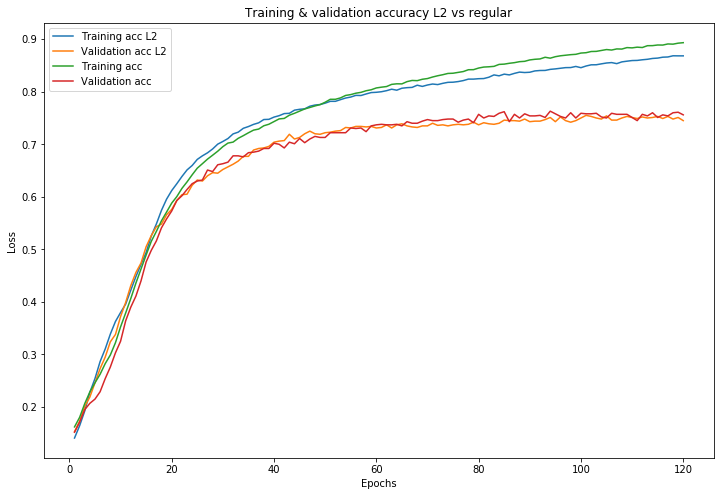

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))

acc_values = L2_model_dict['accuracy'] 
val_acc_values = L2_model_dict['val_accuracy']
model_acc = model_val_dict['accuracy']
model_val_acc = model_val_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L2')
ax.plot(epochs, val_acc_values, label='Validation acc L2')
ax.plot(epochs, model_acc, label='Training acc')
ax.plot(epochs, model_val_acc, label='Validation acc')
ax.set_title('Training & validation accuracy L2 vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

The results of L2 regularization are quite disappointing here. Notice the discrepancy between validation and training accuracy seems to have decreased slightly, but the end result is definitely not getting better. 

## L1 Regularization

Have a look at L1 regularization. Will this work better?

In [38]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(X_train_tok,
                    y_train_lb,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 81us/step - loss: 15.9643 - accuracy: 0.1485 - val_loss: 15.5500 - val_accuracy: 0.1850
Epoch 2/120
7500/7500 [==============================] - 0s 61us/step - loss: 15.2045 - accuracy: 0.1636 - val_loss: 14.8096 - val_accuracy: 0.1920
Epoch 3/120
7500/7500 [==============================] - 0s 60us/step - loss: 14.4740 - accuracy: 0.1839 - val_loss: 14.0938 - val_accuracy: 0.2140
Epoch 4/120
7500/7500 [==============================] - 0s 60us/step - loss: 13.7667 - accuracy: 0.2124 - val_loss: 13.3988 - val_accuracy: 0.2380
Epoch 5/120
7500/7500 [==============================] - 0s 60us/step - loss: 13.0805 - accuracy: 0.2365 - val_loss: 12.7240 - val_accuracy: 0.2700
Epoch 6/120
7500/7500 [==============================] - 0s 60us/step - loss: 12.4141 - accuracy: 0.2679 - val_loss: 12.0687 - val_accuracy: 0.2960
Epoch 7/120
7500/7500 [==============================] - 0s 63us

C:\Users\isali\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.139101). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


7500/7500 [==============================] - 1s 81us/step - loss: 2.1688 - accuracy: 0.6579 - val_loss: 2.1760 - val_accuracy: 0.6610
Epoch 37/120
7500/7500 [==============================] - 0s 61us/step - loss: 2.1327 - accuracy: 0.6637 - val_loss: 2.1445 - val_accuracy: 0.6670
Epoch 38/120
7500/7500 [==============================] - 1s 103us/step - loss: 2.1029 - accuracy: 0.6592 - val_loss: 2.1169 - val_accuracy: 0.6710
Epoch 39/120
7500/7500 [==============================] - 1s 123us/step - loss: 2.0770 - accuracy: 0.6659 - val_loss: 2.0964 - val_accuracy: 0.6600
Epoch 40/120
7500/7500 [==============================] - 1s 102us/step - loss: 2.0534 - accuracy: 0.6649 - val_loss: 2.0715 - val_accuracy: 0.6640
Epoch 41/120
7500/7500 [==============================] - 1s 111us/step - loss: 2.0319 - accuracy: 0.6661 - val_loss: 2.0483 - val_accuracy: 0.6660
Epoch 42/120
7500/7500 [==============================] - 1s 106us/step - loss: 2.0109 - accuracy: 0.6672 - val_loss: 2.0280 - 

7500/7500 [==============================] - 1s 107us/step - loss: 1.5161 - accuracy: 0.6988 - val_loss: 1.5446 - val_accuracy: 0.6990
Epoch 92/120
7500/7500 [==============================] - 1s 103us/step - loss: 1.5097 - accuracy: 0.6967 - val_loss: 1.5340 - val_accuracy: 0.7030
Epoch 93/120
7500/7500 [==============================] - 1s 99us/step - loss: 1.5027 - accuracy: 0.6989 - val_loss: 1.5287 - val_accuracy: 0.7020
Epoch 94/120
7500/7500 [==============================] - 1s 117us/step - loss: 1.4961 - accuracy: 0.6999 - val_loss: 1.5222 - val_accuracy: 0.6930
Epoch 95/120
7500/7500 [==============================] - 1s 116us/step - loss: 1.4899 - accuracy: 0.6997 - val_loss: 1.5151 - val_accuracy: 0.7030
Epoch 96/120
7500/7500 [==============================] - 1s 117us/step - loss: 1.4839 - accuracy: 0.7017 - val_loss: 1.5174 - val_accuracy: 0.6980
Epoch 97/120
7500/7500 [==============================] - 1s 118us/step - loss: 1.4775 - accuracy: 0.7016 - val_loss: 1.5047 -

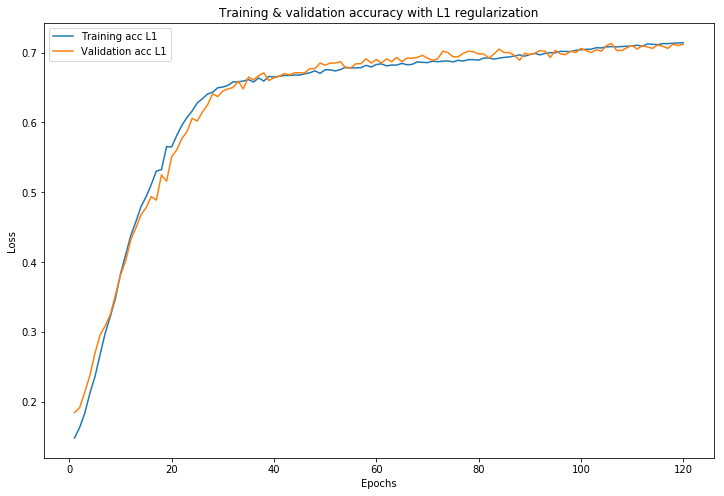

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))

L1_model_dict = L1_model.history

acc_values = L1_model_dict['accuracy'] 
val_acc_values = L1_model_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L1')
ax.plot(epochs, val_acc_values, label='Validation acc L1')
ax.set_title('Training & validation accuracy with L1 regularization')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

Notice how the training and validation accuracy don't diverge as much as before. Unfortunately, the validation accuracy doesn't reach rates much higher than 70%. It does seem like you can still improve the model by training much longer.

In [40]:
# ⏰ This cell may take several minutes to run
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(X_train_tok,
                    y_train_lb,
                    epochs=1000,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/1000
7500/7500 [==============================] - 1s 78us/step - loss: 15.9882 - accuracy: 0.1816 - val_loss: 15.5917 - val_accuracy: 0.1830
Epoch 2/1000
7500/7500 [==============================] - 0s 60us/step - loss: 15.2319 - accuracy: 0.2108 - val_loss: 14.8504 - val_accuracy: 0.1960
Epoch 3/1000
7500/7500 [==============================] - 0s 59us/step - loss: 14.4990 - accuracy: 0.2327 - val_loss: 14.1304 - val_accuracy: 0.2030
Epoch 4/1000
7500/7500 [==============================] - 0s 58us/step - loss: 13.7863 - accuracy: 0.2483 - val_loss: 13.4300 - val_accuracy: 0.2270
Epoch 5/1000
7500/7500 [==============================] - 0s 59us/step - loss: 13.0931 - accuracy: 0.2691 - val_loss: 12.7493 - val_accuracy: 0.2450
Epoch 6/1000
7500/7500 [==============================] - 0s 59us/step - loss: 12.4196 - accuracy: 0.2927 - val_loss: 12.0879 - val_accuracy: 0.2800
Epoch 7/1000
7500/7500 [==============================] - 

Epoch 56/1000
7500/7500 [==============================] - 1s 104us/step - loss: 1.8539 - accuracy: 0.6655 - val_loss: 1.8957 - val_accuracy: 0.6510
Epoch 57/1000
7500/7500 [==============================] - 1s 100us/step - loss: 1.8413 - accuracy: 0.6671 - val_loss: 1.8866 - val_accuracy: 0.6480
Epoch 58/1000
7500/7500 [==============================] - 1s 117us/step - loss: 1.8297 - accuracy: 0.6700 - val_loss: 1.8769 - val_accuracy: 0.6510
Epoch 59/1000
7500/7500 [==============================] - 1s 116us/step - loss: 1.8185 - accuracy: 0.6695 - val_loss: 1.8629 - val_accuracy: 0.6550
Epoch 60/1000
7500/7500 [==============================] - 1s 117us/step - loss: 1.8069 - accuracy: 0.6721 - val_loss: 1.8573 - val_accuracy: 0.6510
Epoch 61/1000
7500/7500 [==============================] - 1s 120us/step - loss: 1.7961 - accuracy: 0.6720 - val_loss: 1.8403 - val_accuracy: 0.6530
Epoch 62/1000
7500/7500 [==============================] - 1s 115us/step - loss: 1.7847 - accuracy: 0.6731

7500/7500 [==============================] - 0s 61us/step - loss: 1.4064 - accuracy: 0.7060 - val_loss: 1.4608 - val_accuracy: 0.6840
Epoch 112/1000
7500/7500 [==============================] - 0s 58us/step - loss: 1.3996 - accuracy: 0.7067 - val_loss: 1.4551 - val_accuracy: 0.6900
Epoch 113/1000
7500/7500 [==============================] - 0s 60us/step - loss: 1.3941 - accuracy: 0.7087 - val_loss: 1.4494 - val_accuracy: 0.6810
Epoch 114/1000
7500/7500 [==============================] - 0s 58us/step - loss: 1.3886 - accuracy: 0.7079 - val_loss: 1.4446 - val_accuracy: 0.6860
Epoch 115/1000
7500/7500 [==============================] - 0s 58us/step - loss: 1.3831 - accuracy: 0.7081 - val_loss: 1.4385 - val_accuracy: 0.6870
Epoch 116/1000
7500/7500 [==============================] - 0s 60us/step - loss: 1.3774 - accuracy: 0.7100 - val_loss: 1.4326 - val_accuracy: 0.6850
Epoch 117/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.3719 - accuracy: 0.7089 - val_loss: 1.

Epoch 166/1000
7500/7500 [==============================] - 1s 120us/step - loss: 1.1703 - accuracy: 0.7296 - val_loss: 1.2363 - val_accuracy: 0.7140
Epoch 167/1000
7500/7500 [==============================] - 1s 112us/step - loss: 1.1678 - accuracy: 0.7308 - val_loss: 1.2335 - val_accuracy: 0.7060
Epoch 168/1000
7500/7500 [==============================] - 1s 72us/step - loss: 1.1644 - accuracy: 0.7295 - val_loss: 1.2302 - val_accuracy: 0.7080
Epoch 169/1000
7500/7500 [==============================] - 1s 73us/step - loss: 1.1618 - accuracy: 0.7325 - val_loss: 1.2276 - val_accuracy: 0.7100
Epoch 170/1000
7500/7500 [==============================] - 1s 84us/step - loss: 1.1587 - accuracy: 0.7320 - val_loss: 1.2268 - val_accuracy: 0.7110
Epoch 171/1000
7500/7500 [==============================] - 1s 107us/step - loss: 1.1563 - accuracy: 0.7297 - val_loss: 1.2223 - val_accuracy: 0.7110
Epoch 172/1000
7500/7500 [==============================] - 1s 92us/step - loss: 1.1536 - accuracy: 0.7

Epoch 221/1000
7500/7500 [==============================] - 1s 113us/step - loss: 1.0638 - accuracy: 0.7444 - val_loss: 1.1368 - val_accuracy: 0.7190
Epoch 222/1000
7500/7500 [==============================] - 1s 99us/step - loss: 1.0628 - accuracy: 0.7439 - val_loss: 1.1393 - val_accuracy: 0.7230
Epoch 223/1000
7500/7500 [==============================] - 1s 70us/step - loss: 1.0614 - accuracy: 0.7428 - val_loss: 1.1340 - val_accuracy: 0.7240
Epoch 224/1000
7500/7500 [==============================] - 1s 75us/step - loss: 1.0607 - accuracy: 0.7431 - val_loss: 1.1333 - val_accuracy: 0.7230
Epoch 225/1000
7500/7500 [==============================] - 1s 80us/step - loss: 1.0590 - accuracy: 0.7460 - val_loss: 1.1313 - val_accuracy: 0.7170
Epoch 226/1000
7500/7500 [==============================] - 1s 107us/step - loss: 1.0579 - accuracy: 0.7437 - val_loss: 1.1331 - val_accuracy: 0.7290
Epoch 227/1000
7500/7500 [==============================] - 1s 117us/step - loss: 1.0565 - accuracy: 0.7

Epoch 276/1000
7500/7500 [==============================] - 1s 116us/step - loss: 1.0060 - accuracy: 0.7557 - val_loss: 1.0871 - val_accuracy: 0.7290
Epoch 277/1000
7500/7500 [==============================] - 1s 118us/step - loss: 1.0055 - accuracy: 0.7541 - val_loss: 1.0841 - val_accuracy: 0.7350
Epoch 278/1000
7500/7500 [==============================] - 1s 117us/step - loss: 1.0042 - accuracy: 0.7543 - val_loss: 1.0846 - val_accuracy: 0.7390
Epoch 279/1000
7500/7500 [==============================] - 1s 109us/step - loss: 1.0029 - accuracy: 0.7572 - val_loss: 1.0834 - val_accuracy: 0.7340
Epoch 280/1000
7500/7500 [==============================] - 0s 64us/step - loss: 1.0024 - accuracy: 0.7553 - val_loss: 1.0915 - val_accuracy: 0.7190
Epoch 281/1000
7500/7500 [==============================] - 1s 100us/step - loss: 1.0014 - accuracy: 0.7549 - val_loss: 1.0893 - val_accuracy: 0.7250
Epoch 282/1000
7500/7500 [==============================] - 1s 118us/step - loss: 1.0010 - accuracy: 

Epoch 331/1000
7500/7500 [==============================] - 1s 100us/step - loss: 0.9651 - accuracy: 0.7651 - val_loss: 1.0512 - val_accuracy: 0.7460
Epoch 332/1000
7500/7500 [==============================] - 1s 96us/step - loss: 0.9649 - accuracy: 0.7615 - val_loss: 1.0512 - val_accuracy: 0.7430
Epoch 333/1000
7500/7500 [==============================] - 1s 88us/step - loss: 0.9634 - accuracy: 0.7623 - val_loss: 1.0500 - val_accuracy: 0.7410
Epoch 334/1000
7500/7500 [==============================] - 1s 100us/step - loss: 0.9634 - accuracy: 0.7635 - val_loss: 1.0483 - val_accuracy: 0.7400
Epoch 335/1000
7500/7500 [==============================] - 1s 101us/step - loss: 0.9623 - accuracy: 0.7647 - val_loss: 1.0474 - val_accuracy: 0.7410
Epoch 336/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.9627 - accuracy: 0.7621 - val_loss: 1.0525 - val_accuracy: 0.7420
Epoch 337/1000
7500/7500 [==============================] - 1s 117us/step - loss: 0.9618 - accuracy: 0

Epoch 386/1000
7500/7500 [==============================] - 1s 115us/step - loss: 0.9354 - accuracy: 0.7684 - val_loss: 1.0303 - val_accuracy: 0.7460
Epoch 387/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.9351 - accuracy: 0.7693 - val_loss: 1.0276 - val_accuracy: 0.7480
Epoch 388/1000
7500/7500 [==============================] - 1s 115us/step - loss: 0.9346 - accuracy: 0.7668 - val_loss: 1.0305 - val_accuracy: 0.7380
Epoch 389/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.9345 - accuracy: 0.7680 - val_loss: 1.0422 - val_accuracy: 0.7330
Epoch 390/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.9339 - accuracy: 0.7701 - val_loss: 1.0286 - val_accuracy: 0.7480
Epoch 391/1000
7500/7500 [==============================] - 1s 117us/step - loss: 0.9348 - accuracy: 0.7665 - val_loss: 1.0371 - val_accuracy: 0.7350
Epoch 392/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.9326 - accuracy:

7500/7500 [==============================] - 1s 117us/step - loss: 0.9126 - accuracy: 0.7721 - val_loss: 1.0130 - val_accuracy: 0.7470
Epoch 441/1000
7500/7500 [==============================] - 1s 117us/step - loss: 0.9130 - accuracy: 0.7737 - val_loss: 1.0237 - val_accuracy: 0.7420
Epoch 442/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.9131 - accuracy: 0.7741 - val_loss: 1.0117 - val_accuracy: 0.7480
Epoch 443/1000
7500/7500 [==============================] - 1s 98us/step - loss: 0.9122 - accuracy: 0.7711 - val_loss: 1.0120 - val_accuracy: 0.7500
Epoch 444/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.9109 - accuracy: 0.7732 - val_loss: 1.0100 - val_accuracy: 0.7460
Epoch 445/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.9113 - accuracy: 0.7733 - val_loss: 1.0118 - val_accuracy: 0.7440
Epoch 446/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.9108 - accuracy: 0.7735 - val_lo

7500/7500 [==============================] - 1s 76us/step - loss: 0.8961 - accuracy: 0.7807 - val_loss: 1.0020 - val_accuracy: 0.7490
Epoch 495/1000
7500/7500 [==============================] - 1s 70us/step - loss: 0.8948 - accuracy: 0.7765 - val_loss: 1.0004 - val_accuracy: 0.7530
Epoch 496/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.8954 - accuracy: 0.7795 - val_loss: 1.0005 - val_accuracy: 0.7510
Epoch 497/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.8957 - accuracy: 0.7768 - val_loss: 1.0053 - val_accuracy: 0.7500
Epoch 498/1000
7500/7500 [==============================] - 0s 60us/step - loss: 0.8956 - accuracy: 0.7780 - val_loss: 1.0058 - val_accuracy: 0.7460
Epoch 499/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.8951 - accuracy: 0.7797 - val_loss: 1.0071 - val_accuracy: 0.7500
Epoch 500/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.8950 - accuracy: 0.7801 - val_loss: 1.

Epoch 549/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.8845 - accuracy: 0.7780 - val_loss: 0.9937 - val_accuracy: 0.7520
Epoch 550/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.8826 - accuracy: 0.7823 - val_loss: 0.9897 - val_accuracy: 0.7570
Epoch 551/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.8824 - accuracy: 0.7824 - val_loss: 1.0142 - val_accuracy: 0.7380
Epoch 552/1000
7500/7500 [==============================] - 1s 90us/step - loss: 0.8829 - accuracy: 0.7813 - val_loss: 1.0030 - val_accuracy: 0.7540
Epoch 553/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8829 - accuracy: 0.7791 - val_loss: 0.9889 - val_accuracy: 0.7590
Epoch 554/1000
7500/7500 [==============================] - 1s 77us/step - loss: 0.8815 - accuracy: 0.7836 - val_loss: 1.0169 - val_accuracy: 0.7430
Epoch 555/1000
7500/7500 [==============================] - 1s 100us/step - loss: 0.8841 - accuracy: 0.

Epoch 604/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.8732 - accuracy: 0.7863 - val_loss: 0.9895 - val_accuracy: 0.7520
Epoch 605/1000
7500/7500 [==============================] - 1s 115us/step - loss: 0.8725 - accuracy: 0.7855 - val_loss: 0.9914 - val_accuracy: 0.7510
Epoch 606/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.8725 - accuracy: 0.7861 - val_loss: 0.9904 - val_accuracy: 0.7520
Epoch 607/1000
7500/7500 [==============================] - 1s 118us/step - loss: 0.8731 - accuracy: 0.7856 - val_loss: 0.9921 - val_accuracy: 0.7540
Epoch 608/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.8717 - accuracy: 0.7865 - val_loss: 0.9882 - val_accuracy: 0.7540
Epoch 609/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.8726 - accuracy: 0.7844 - val_loss: 0.9888 - val_accuracy: 0.7560
Epoch 610/1000
7500/7500 [==============================] - 1s 88us/step - loss: 0.8715 - accuracy: 

Epoch 659/1000
7500/7500 [==============================] - 0s 62us/step - loss: 0.8626 - accuracy: 0.7891 - val_loss: 0.9840 - val_accuracy: 0.7530
Epoch 660/1000
7500/7500 [==============================] - 0s 60us/step - loss: 0.8625 - accuracy: 0.7888 - val_loss: 0.9818 - val_accuracy: 0.7530
Epoch 661/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8628 - accuracy: 0.7881 - val_loss: 0.9846 - val_accuracy: 0.7550
Epoch 662/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8618 - accuracy: 0.7888 - val_loss: 0.9968 - val_accuracy: 0.7470
Epoch 663/1000
7500/7500 [==============================] - 0s 60us/step - loss: 0.8631 - accuracy: 0.7907 - val_loss: 0.9888 - val_accuracy: 0.7510
Epoch 664/1000
7500/7500 [==============================] - 1s 97us/step - loss: 0.8634 - accuracy: 0.7885 - val_loss: 0.9846 - val_accuracy: 0.7560
Epoch 665/1000
7500/7500 [==============================] - 0s 63us/step - loss: 0.8631 - accuracy: 0.7877

Epoch 714/1000
7500/7500 [==============================] - 1s 85us/step - loss: 0.8551 - accuracy: 0.7903 - val_loss: 0.9900 - val_accuracy: 0.7570
Epoch 715/1000
7500/7500 [==============================] - 1s 100us/step - loss: 0.8555 - accuracy: 0.7915 - val_loss: 0.9902 - val_accuracy: 0.7580
Epoch 716/1000
7500/7500 [==============================] - 1s 105us/step - loss: 0.8541 - accuracy: 0.7923 - val_loss: 0.9803 - val_accuracy: 0.7660
Epoch 717/1000
7500/7500 [==============================] - 1s 117us/step - loss: 0.8548 - accuracy: 0.7912 - val_loss: 1.0161 - val_accuracy: 0.7400
Epoch 718/1000
7500/7500 [==============================] - 1s 118us/step - loss: 0.8554 - accuracy: 0.7945 - val_loss: 0.9815 - val_accuracy: 0.7560
Epoch 719/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.8534 - accuracy: 0.7923 - val_loss: 0.9763 - val_accuracy: 0.7570
Epoch 720/1000
7500/7500 [==============================] - 1s 83us/step - loss: 0.8528 - accuracy: 0

Epoch 769/1000
7500/7500 [==============================] - 1s 75us/step - loss: 0.8468 - accuracy: 0.7957 - val_loss: 0.9825 - val_accuracy: 0.7570
Epoch 770/1000
7500/7500 [==============================] - 0s 64us/step - loss: 0.8458 - accuracy: 0.7928 - val_loss: 1.0034 - val_accuracy: 0.7420
Epoch 771/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8482 - accuracy: 0.7940 - val_loss: 0.9750 - val_accuracy: 0.7550
Epoch 772/1000
7500/7500 [==============================] - 0s 63us/step - loss: 0.8449 - accuracy: 0.7959 - val_loss: 0.9928 - val_accuracy: 0.7500
Epoch 773/1000
7500/7500 [==============================] - 0s 60us/step - loss: 0.8462 - accuracy: 0.7943 - val_loss: 0.9917 - val_accuracy: 0.7510
Epoch 774/1000
7500/7500 [==============================] - 0s 63us/step - loss: 0.8470 - accuracy: 0.7943 - val_loss: 0.9912 - val_accuracy: 0.7530
Epoch 775/1000
7500/7500 [==============================] - 1s 67us/step - loss: 0.8454 - accuracy: 0.7975

Epoch 824/1000
7500/7500 [==============================] - 1s 105us/step - loss: 0.8393 - accuracy: 0.7999 - val_loss: 0.9751 - val_accuracy: 0.7510
Epoch 825/1000
7500/7500 [==============================] - 1s 118us/step - loss: 0.8397 - accuracy: 0.7976 - val_loss: 0.9756 - val_accuracy: 0.7590
Epoch 826/1000
7500/7500 [==============================] - 1s 116us/step - loss: 0.8380 - accuracy: 0.7957 - val_loss: 0.9765 - val_accuracy: 0.7580
Epoch 827/1000
7500/7500 [==============================] - 1s 119us/step - loss: 0.8366 - accuracy: 0.7980 - val_loss: 0.9796 - val_accuracy: 0.7550
Epoch 828/1000
7500/7500 [==============================] - 1s 87us/step - loss: 0.8377 - accuracy: 0.7983 - val_loss: 1.0077 - val_accuracy: 0.7410
Epoch 829/1000
7500/7500 [==============================] - 1s 104us/step - loss: 0.8396 - accuracy: 0.7964 - val_loss: 0.9784 - val_accuracy: 0.7560
Epoch 830/1000
7500/7500 [==============================] - 1s 109us/step - loss: 0.8383 - accuracy: 

Epoch 879/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8333 - accuracy: 0.8024 - val_loss: 0.9731 - val_accuracy: 0.7570
Epoch 880/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8309 - accuracy: 0.8009 - val_loss: 0.9822 - val_accuracy: 0.7590
Epoch 881/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8311 - accuracy: 0.8003 - val_loss: 0.9780 - val_accuracy: 0.7540
Epoch 882/1000
7500/7500 [==============================] - 0s 62us/step - loss: 0.8305 - accuracy: 0.7996 - val_loss: 0.9744 - val_accuracy: 0.7560
Epoch 883/1000
7500/7500 [==============================] - 0s 60us/step - loss: 0.8317 - accuracy: 0.8004 - val_loss: 0.9695 - val_accuracy: 0.7570
Epoch 884/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8308 - accuracy: 0.7985 - val_loss: 0.9893 - val_accuracy: 0.7580
Epoch 885/1000
7500/7500 [==============================] - 0s 62us/step - loss: 0.8317 - accuracy: 0.7991

Epoch 934/1000
7500/7500 [==============================] - 0s 62us/step - loss: 0.8278 - accuracy: 0.8037 - val_loss: 1.0089 - val_accuracy: 0.7360
Epoch 935/1000
7500/7500 [==============================] - 0s 60us/step - loss: 0.8249 - accuracy: 0.8060 - val_loss: 0.9804 - val_accuracy: 0.7460
Epoch 936/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8253 - accuracy: 0.8044 - val_loss: 0.9681 - val_accuracy: 0.7550
Epoch 937/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8250 - accuracy: 0.8067 - val_loss: 0.9860 - val_accuracy: 0.7540
Epoch 938/1000
7500/7500 [==============================] - 0s 62us/step - loss: 0.8233 - accuracy: 0.8052 - val_loss: 1.0021 - val_accuracy: 0.7430
Epoch 939/1000
7500/7500 [==============================] - 0s 62us/step - loss: 0.8264 - accuracy: 0.8049 - val_loss: 0.9904 - val_accuracy: 0.7410
Epoch 940/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8243 - accuracy: 0.8053

Epoch 989/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8168 - accuracy: 0.8132 - val_loss: 0.9653 - val_accuracy: 0.7610
Epoch 990/1000
7500/7500 [==============================] - 0s 60us/step - loss: 0.8188 - accuracy: 0.8076 - val_loss: 0.9708 - val_accuracy: 0.7600
Epoch 991/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.8170 - accuracy: 0.8077 - val_loss: 0.9893 - val_accuracy: 0.7570
Epoch 992/1000
7500/7500 [==============================] - 0s 62us/step - loss: 0.8201 - accuracy: 0.8048 - val_loss: 0.9756 - val_accuracy: 0.7520
Epoch 993/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8193 - accuracy: 0.8108 - val_loss: 0.9688 - val_accuracy: 0.7620
Epoch 994/1000
7500/7500 [==============================] - 0s 60us/step - loss: 0.8183 - accuracy: 0.8083 - val_loss: 0.9939 - val_accuracy: 0.7530
Epoch 995/1000
7500/7500 [==============================] - 0s 62us/step - loss: 0.8198 - accuracy: 0.8083

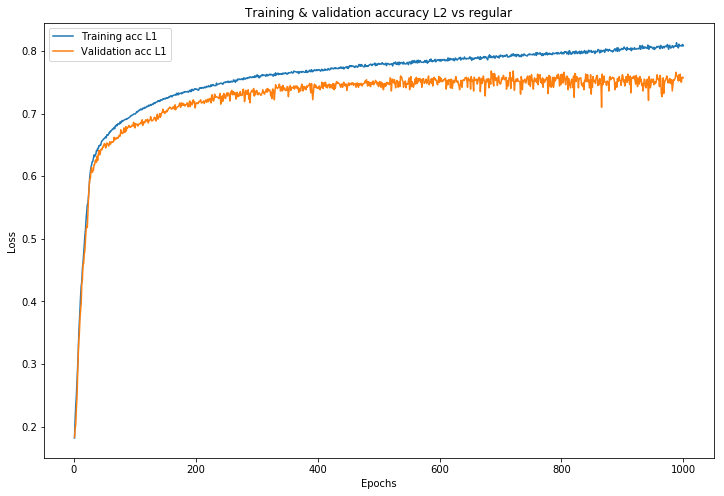

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))

L1_model_dict = L1_model.history

acc_values = L1_model_dict['accuracy'] 
val_acc_values = L1_model_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L1')
ax.plot(epochs, val_acc_values, label='Validation acc L1')
ax.set_title('Training & validation accuracy L2 vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

In [42]:
results_train = model.evaluate(X_train_tok, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')   

7500/7500 [==============================] - 0s 54us/step
Training Loss: 0.812 Training Accuracy: 0.814
1500/1500 [==============================] - 0s 63us/step
Testing Loss: 0.88 Testing Accuracy: 0.787


This is about the best result you've achieved so far, but you were training for quite a while! Next, experiment with dropout regularization to see if it offers any advantages.

## Dropout Regularization

In [43]:
# ⏰ This cell may take about a minute to run
random.seed(123)
model = models.Sequential()
model.add(layers.Dropout(0.3, input_shape=(2000,)))
model.add(layers.Dense(50, activation='relu')) #2 hidden layers
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

dropout_model = model.fit(X_train_tok,
                    y_train_lb,
                    epochs=200,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/200
7500/7500 [==============================] - 1s 141us/step - loss: 1.9778 - accuracy: 0.1619 - val_loss: 1.9353 - val_accuracy: 0.1800
Epoch 2/200
7500/7500 [==============================] - 1s 106us/step - loss: 1.9465 - accuracy: 0.1804 - val_loss: 1.9202 - val_accuracy: 0.1880
Epoch 3/200
7500/7500 [==============================] - 1s 107us/step - loss: 1.9365 - accuracy: 0.1823 - val_loss: 1.9084 - val_accuracy: 0.1950
Epoch 4/200
7500/7500 [==============================] - 1s 105us/step - loss: 1.9156 - accuracy: 0.2012 - val_loss: 1.8963 - val_accuracy: 0.2080
Epoch 5/200
7500/7500 [==============================] - 1s 104us/step - loss: 1.9047 - accuracy: 0.2031 - val_loss: 1.8846 - val_accuracy: 0.2240
Epoch 6/200
7500/7500 [==============================] - 1s 108us/step - loss: 1.8981 - accuracy: 0.2120 - val_loss: 1.8728 - val_accuracy: 0.2370
Epoch 7/200
7500/7500 [==============================] - 1s 106us/step

7500/7500 [==============================] - 1s 101us/step - loss: 1.2043 - accuracy: 0.5436 - val_loss: 1.0156 - val_accuracy: 0.6840
Epoch 57/200
7500/7500 [==============================] - 1s 109us/step - loss: 1.1891 - accuracy: 0.5553 - val_loss: 1.0058 - val_accuracy: 0.6930
Epoch 58/200
7500/7500 [==============================] - 1s 103us/step - loss: 1.1965 - accuracy: 0.5549 - val_loss: 0.9993 - val_accuracy: 0.7030
Epoch 59/200
7500/7500 [==============================] - 1s 99us/step - loss: 1.1859 - accuracy: 0.5524 - val_loss: 0.9936 - val_accuracy: 0.7020
Epoch 60/200
7500/7500 [==============================] - 1s 152us/step - loss: 1.1666 - accuracy: 0.5657 - val_loss: 0.9828 - val_accuracy: 0.7040
Epoch 61/200
7500/7500 [==============================] - 1s 100us/step - loss: 1.1522 - accuracy: 0.5655 - val_loss: 0.9734 - val_accuracy: 0.7070
Epoch 62/200
7500/7500 [==============================] - 1s 99us/step - loss: 1.1624 - accuracy: 0.5641 - val_loss: 0.9697 - 

7500/7500 [==============================] - 1s 103us/step - loss: 0.9179 - accuracy: 0.6589 - val_loss: 0.7665 - val_accuracy: 0.7430
Epoch 112/200
7500/7500 [==============================] - 1s 98us/step - loss: 0.9196 - accuracy: 0.6615 - val_loss: 0.7633 - val_accuracy: 0.7410
Epoch 113/200
7500/7500 [==============================] - 1s 99us/step - loss: 0.9274 - accuracy: 0.6509 - val_loss: 0.7621 - val_accuracy: 0.7450
Epoch 114/200
7500/7500 [==============================] - 1s 100us/step - loss: 0.9340 - accuracy: 0.6580 - val_loss: 0.7614 - val_accuracy: 0.7400
Epoch 115/200
7500/7500 [==============================] - 1s 97us/step - loss: 0.9049 - accuracy: 0.6712 - val_loss: 0.7583 - val_accuracy: 0.7420
Epoch 116/200
7500/7500 [==============================] - 1s 121us/step - loss: 0.9176 - accuracy: 0.6625 - val_loss: 0.7558 - val_accuracy: 0.7420
Epoch 117/200
7500/7500 [==============================] - 1s 98us/step - loss: 0.9181 - accuracy: 0.6561 - val_loss: 0.754

7500/7500 [==============================] - 1s 116us/step - loss: 0.7931 - accuracy: 0.7091 - val_loss: 0.6883 - val_accuracy: 0.7560
Epoch 167/200
7500/7500 [==============================] - 1s 117us/step - loss: 0.8001 - accuracy: 0.7012 - val_loss: 0.6880 - val_accuracy: 0.7540
Epoch 168/200
7500/7500 [==============================] - 1s 154us/step - loss: 0.7836 - accuracy: 0.7083 - val_loss: 0.6856 - val_accuracy: 0.7550
Epoch 169/200
7500/7500 [==============================] - 1s 135us/step - loss: 0.7950 - accuracy: 0.7009 - val_loss: 0.6861 - val_accuracy: 0.7540
Epoch 170/200
7500/7500 [==============================] - 1s 170us/step - loss: 0.7856 - accuracy: 0.7053 - val_loss: 0.6842 - val_accuracy: 0.7510
Epoch 171/200
7500/7500 [==============================] - 1s 174us/step - loss: 0.8081 - accuracy: 0.7011 - val_loss: 0.6846 - val_accuracy: 0.7540
Epoch 172/200
7500/7500 [==============================] - 1s 169us/step - loss: 0.7828 - accuracy: 0.7104 - val_loss: 0

In [44]:
results_train = model.evaluate(X_train_tok, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')   

7500/7500 [==============================] - 1s 68us/step
Training Loss: 0.457 Training Accuracy: 0.849
1500/1500 [==============================] - 0s 98us/step
Testing Loss: 0.573 Testing Accuracy: 0.791


You can see here that the validation performance has improved again! The variance did become higher again compared to L1-regularization.

## Bigger Data?

In the lecture, one of the solutions to high variance was just getting more data. You actually *have* more data, but took a subset of 10,000 units before. Let's now quadruple your data set, and see what happens. Note that you are really just lucky here, and getting more data isn't always possible, but this is a useful exercise in order to understand the power of big data sets.

In [45]:
df = pd.read_csv('Bank_complaints.csv')
df = df.sample(40000, random_state=123)

X = df["Consumer complaint narrative"]
y = df["Product"]

# train test split
X_train_lrg, X_test_lrg, y_train_lrg, y_test_lrg = train_test_split(X, y, random_state=42)

#Validation set
X_train_final_lrg, X_val_lrg, y_train_final_lrg, y_val_lrg = train_test_split(X_train_lrg, y_train_lrg, random_state=123)


#one-hot encoding of the complaints
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train_final_lrg)

X_train_tok_lrg = tokenizer.texts_to_matrix(X_train_final_lrg, mode='binary')
X_val_lrg = tokenizer.texts_to_matrix(X_val_lrg, mode='binary')
X_test_lrg = tokenizer.texts_to_matrix(X_test_lrg, mode='binary')

#one-hot encoding of products
lb = LabelBinarizer()
lb.fit(y_train_final_lrg)

y_train_lb_lrg = to_categorical(lb.transform(y_train_final_lrg))[:, :, 1]
y_val_lrg = to_categorical(lb.transform(y_val_lrg))[:, :, 1]
y_test_lrg = to_categorical(lb.transform(y_test_lrg))[:, :, 1]

In [46]:
# ⏰ This cell may take several minutes to run
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

moredata_model = model.fit(X_train_tok_lrg,
                    y_train_lb_lrg,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val_lrg, y_val_lrg))

Train on 22500 samples, validate on 7500 samples
Epoch 1/120
22500/22500 [==============================] - 2s 73us/step - loss: 1.9311 - accuracy: 0.1720 - val_loss: 1.9028 - val_accuracy: 0.2203
Epoch 2/120
22500/22500 [==============================] - 2s 68us/step - loss: 1.8656 - accuracy: 0.2667 - val_loss: 1.8292 - val_accuracy: 0.3015
Epoch 3/120
22500/22500 [==============================] - 2s 87us/step - loss: 1.7749 - accuracy: 0.3419 - val_loss: 1.7231 - val_accuracy: 0.3727
Epoch 4/120
22500/22500 [==============================] - 2s 68us/step - loss: 1.6585 - accuracy: 0.4022 - val_loss: 1.5988 - val_accuracy: 0.4383
Epoch 5/120
22500/22500 [==============================] - 2s 67us/step - loss: 1.5309 - accuracy: 0.4579 - val_loss: 1.4691 - val_accuracy: 0.4860
Epoch 6/120
22500/22500 [==============================] - 2s 67us/step - loss: 1.4045 - accuracy: 0.5099 - val_loss: 1.3461 - val_accuracy: 0.5365
Epoch 7/120
22500/22500 [==============================] - 2s 6

Epoch 56/120
22500/22500 [==============================] - 1s 66us/step - loss: 0.4359 - accuracy: 0.8466 - val_loss: 0.5811 - val_accuracy: 0.7924
Epoch 57/120
22500/22500 [==============================] - 1s 65us/step - loss: 0.4325 - accuracy: 0.8488 - val_loss: 0.5798 - val_accuracy: 0.7948
Epoch 58/120
22500/22500 [==============================] - 1s 65us/step - loss: 0.4291 - accuracy: 0.8488 - val_loss: 0.5805 - val_accuracy: 0.7941
Epoch 59/120
22500/22500 [==============================] - 1s 65us/step - loss: 0.4262 - accuracy: 0.8505 - val_loss: 0.5801 - val_accuracy: 0.7944
Epoch 60/120
22500/22500 [==============================] - 2s 73us/step - loss: 0.4228 - accuracy: 0.8523 - val_loss: 0.5800 - val_accuracy: 0.7951
Epoch 61/120
22500/22500 [==============================] - 2s 89us/step - loss: 0.4197 - accuracy: 0.8526 - val_loss: 0.5797 - val_accuracy: 0.7944
Epoch 62/120
22500/22500 [==============================] - 1s 65us/step - loss: 0.4173 - accuracy: 0.8538

Epoch 111/120
22500/22500 [==============================] - 3s 112us/step - loss: 0.3136 - accuracy: 0.8940 - val_loss: 0.6051 - val_accuracy: 0.7976
Epoch 112/120
22500/22500 [==============================] - 1s 65us/step - loss: 0.3119 - accuracy: 0.8947 - val_loss: 0.6067 - val_accuracy: 0.7953
Epoch 113/120
22500/22500 [==============================] - 1s 65us/step - loss: 0.3106 - accuracy: 0.8956 - val_loss: 0.6071 - val_accuracy: 0.7973
Epoch 114/120
22500/22500 [==============================] - 1s 66us/step - loss: 0.3095 - accuracy: 0.8955 - val_loss: 0.6074 - val_accuracy: 0.7987
Epoch 115/120
22500/22500 [==============================] - 1s 65us/step - loss: 0.3076 - accuracy: 0.8972 - val_loss: 0.6148 - val_accuracy: 0.7928
Epoch 116/120
22500/22500 [==============================] - 2s 67us/step - loss: 0.3059 - accuracy: 0.8970 - val_loss: 0.6090 - val_accuracy: 0.7980
Epoch 117/120
22500/22500 [==============================] - 1s 65us/step - loss: 0.3039 - accuracy

In [47]:
results_train = model.evaluate(X_train_tok_lrg, y_train_lb_lrg)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_lrg, y_test_lrg)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

22500/22500 [==============================] - 1s 52us/step
Training Loss: 0.295 Training Accuracy: 0.902
10000/10000 [==============================] - 1s 54us/step
Testing Loss: 0.613 Testing Accuracy: 0.789


With the same amount of epochs, you were able to get a fairly similar validation accuracy of 89.67 (compared to 88.45 in obtained in the first model in this lab). Your test set accuracy went up from 75.8 to 79.2% though, without any other regularization technique. You can still consider early stopping, L1, L2 and dropout here. It's clear that having more data has a strong impact on model performance!

## Additional Resources

* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb
* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
* https://catalog.data.gov/dataset/consumer-complaint-database

## Summary  

In this lesson, you not only built an initial deep-learning model, you then used a validation set to tune your model using various types of regularization.